In [ ]:
import torch as T
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

Text(0.5, 1.0, 'Image label: 1')

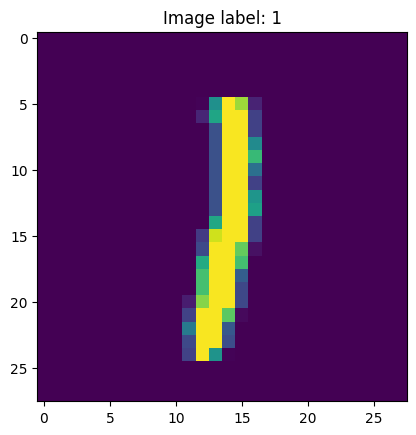

In [ ]:
train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Reshape input to (batch_size, channels, height, width)
        x = x.view(-1, 1, 28, 28)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN()
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


In [ ]:
from torch.nn.functional import cross_entropy
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_data_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0488
Epoch [2/5], Loss: 0.0084
Epoch [3/5], Loss: 0.0243
Epoch [4/5], Loss: 0.0099
Epoch [5/5], Loss: 0.0008


In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
print(f'Neural network accuracy on train set: {train_acc}')

Neural network accuracy on train set: 0.9971666932106018


In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine.'

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

--2023-11-18 13:11:48--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw07_data_dict.npy’

hw07_data_dict.npy  100%[===================>]   5.98M  --.-KB/s    in 0.09s   

2023-11-18 13:11:49 (66.9 MB/s) - ‘hw07_data_dict.npy’ saved [6272438/6272438]



In [ ]:
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))

    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')

File saved to `submission_dict_hw07.npy`
